# **Машинное обучение ИБ-2024**

# **Домашнее задание 3.**

# Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [144]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import matplotlib as plt

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### 1. Предобработка
1. Remove punctuation
2. Remove digits
3. Remove english stopwords
4. Transform to lower
5. Проверка балансировки классов

In [146]:
df=pd.read_csv('combined_data.csv')

In [147]:
df_raw=df[:5_000].copy()
df_raw.shape[0]

5000

In [148]:
del(df)

In [149]:
import re
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()
from nltk.corpus import stopwords

def clean_text(input_text):
    # Удаление знаков препинания и цифр
    text = re.sub(r'[^\w\s]', '', input_text)  # Удалить знаки препинания
    text = re.sub(r'\d+', '', text)  # Удалить цифры

    # Преобразуем строку в список слов
    words = text.split()

    # Подгрузка стоп-слов
    stop_words = set(stopwords.words('english'))

    # Удаление стоп-слов
    filtered_words = [
        word.lower() for word in words
        if word.lower() not in stop_words
        and len(word) > 1
      ]

    # Возврат очищенного текста
    return ' '.join(filtered_words)

def clean_column(row):
    return clean_text(row['text'])

df_raw['text']=df_raw.progress_apply(clean_column, axis=1)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [150]:
df_raw.label.value_counts()

,count
label,
1,2675
0,2325


Классы сбалансированные, а значит подойдет метрика accuracy в качестве основной метрики

### 2. Лемматизация

In [151]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [152]:
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    """Описание метода:
        Сперва текст превращается в набор токенов -> лексических единиц
        Затем каждый из токенов проходит лемматизацию
        лемматизация - процесс приведения слов к их каноничной форме
        Алгоритмы лемматизации работают следующим образом:
        1. Анализ части речи, к которой принадлежит токен
        2. Подбор канонической формы по словарю
    """
    tokens = word_tokenize(text)
    lemmatized_sentence = [
        lemmatizer.lemmatize(token) for token in tokens
    ]
    return ' '.join(lemmatized_sentence)

def apply_lemmatization(row):
    text=row['text']
    return lemmatize_text(text)


df_lemmatized = df_raw.copy()
df_lemmatized['text']=df_lemmatized.progress_apply(apply_lemmatization, axis=1)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [153]:
del(df_raw)

### 3. Приведение текстов к векторам

#### 3.1 Bag of Words

In [154]:
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer

# Make dict for vectors
vectorizer = CountVectorizer(max_features=5_000, min_df=5)
# Трансформируем текст в матрицу частот слов
bow = vectorizer.fit_transform(df_lemmatized['text'])

In [155]:
count_array = bow.toarray()

In [159]:
features = vectorizer.get_feature_names_out()
features.shape[0]

5000

In [158]:
df_vectors = pd.DataFrame(data=count_array, columns=features)
df_vectors.shape[0]

5000

#### 3.2 TfIdf

In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(max_features=5_000, min_df=5)
# tokenize and build vocab
tfidf = vectorizer.fit_transform(df_lemmatized['text'])


In [161]:
tfidf_array = tfidf.toarray()
features = vectorizer.get_feature_names_out()

In [162]:
df_tfidf_vectors = pd.DataFrame(data=tfidf_array, columns=features)
df_tfidf_vectors.shape[0]

5000

#### 3.3 Сохраняем датасет в csv в качестве чекпоинта

In [14]:
# Таргетные лейблы
df_lemmatized['label'].to_csv('target.csv')
# Фичи
df_tfidf_vectors.to_csv('features.csv')

### 4. Разбиение выборки на test и train

In [163]:
from sklearn.model_selection import train_test_split

target=df_lemmatized['label'].values
features=df_tfidf_vectors

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=151)

### 5. Кросс-валидация + подбор гиперпараметров

In [164]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)

#### 5.0 Выбор метрики для оценки кросс-валидации:

Accuracy: TP + TN / (TP + TN + FP + FN)<br>
Применение при:
1. Сбалансированных класса (в целом на этом все)


Precision: TP / (TP + FP)

Recall: TP / (TP + FN)

F1 score: 2 * Precision * Recall / (Precision + Recall)<br>
Помогает при несбалансированных классах так как усредняет recall и precision и минимизирует как fp так и fn ошибкти в совокупности

#### 5.1 Логистическая регрессия

In [165]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
}

In [166]:
lr = LogisticRegression(max_iter=50)

In [167]:
#scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scoring='accuracy'
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5,
                              scoring=scoring, refit='accuracy')

In [168]:
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=50),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'lbfgs']},
             refit='accuracy', scoring='accuracy')

In [169]:
print("Лучшие параметры для Logistic Regression:", grid_search_lr.best_params_)

Лучшие параметры для Logistic Regression: {'C': 100, 'solver': 'lbfgs'}


In [170]:
best_lr = grid_search_lr.best_estimator_

In [171]:
y_pred_lr = best_lr.predict(X_test)

In [172]:
print("Logistic Regression prediction results:")
print(f"Accuracy:\t{accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision:\t{precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: \t{recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 score:\t{f1_score(y_test, y_pred_lr):.4f}")
print(f"Roc Auc:\t{roc_auc_score(y_test, y_pred_lr):.4f}")

Logistic Regression prediction results:
Accuracy:	0.9640
Precision:	0.9549
Recall: 	0.9769
F1 score:	0.9658
Roc Auc:	0.9635


#### 5.2 Random Forest

In [173]:
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 10],
}

In [174]:
rf = RandomForestClassifier()

In [175]:
#scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scoring='accuracy'

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5,
                              scoring=scoring, refit='accuracy')

In [176]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 30],
                         'min_samples_split': [2, 10],
                         'n_estimators': [50, 100]},
             refit='accuracy', scoring='accuracy')

In [177]:
print("Лучшие параметры для Random Forest:", grid_search_rf.best_params_)

Лучшие параметры для Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [178]:
best_rf = grid_search_rf.best_estimator_

In [179]:
y_pred_rf = best_rf.predict(X_test)

In [180]:
print("Random Forest prediction results:")
print(f"Accuracy:\t{accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision:\t{precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: \t{recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 score:\t{f1_score(y_test, y_pred_rf):.4f}")
print(f"Roc Auc:\t{roc_auc_score(y_test, y_pred_rf):.4f}")

Random Forest prediction results:
Accuracy:	0.9670
Precision:	0.9656
Recall: 	0.9712
F1 score:	0.9684
Roc Auc:	0.9668


#### 5.3 XGBoost

In [181]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
}

In [182]:
xgb = XGBClassifier(eval_metric='mlogloss')

In [183]:
scoring='accuracy'
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring=scoring)

In [184]:
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [185]:
print("Лучшие параметры для XGBoost:", grid_search_xgb.best_params_)

Лучшие параметры для XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


In [186]:
best_xgb = grid_search_xgb.best_estimator_

In [187]:
y_pred_xgb = best_xgb.predict(X_test)

In [188]:
print("XGB prediction results:")
print(f"Accuracy:\t{accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision:\t{precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: \t{recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 score:\t{f1_score(y_test, y_pred_xgb):.4f}")
print(f"Roc Auc:\t{roc_auc_score(y_test, y_pred_xgb):.4f}")

XGB prediction results:
Accuracy:	0.9630
Precision:	0.9448
Recall: 	0.9865
F1 score:	0.9652
Roc Auc:	0.9620


## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

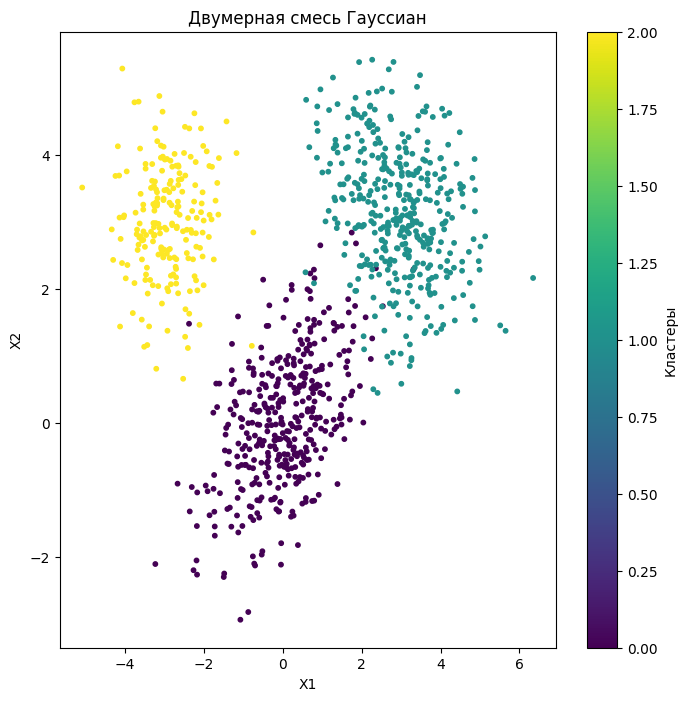

In [189]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

In [190]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

In [191]:
n_clusters_list = list(range(2, 15))
score_list = []

In [192]:
for n_clusters in n_clusters_list:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    score = silhouette_score(X, cluster_labels)
    score_list.append(score)
    #print(f"N clusters {n_clusters}: {score}")

In [193]:
extremum_pos=score_list.index(max(score_list)) + n_clusters_list[0]
print(f"Наивероятнейшее кол-во кластеров: {extremum_pos}")

Наивероятнейшее кол-во кластеров: 3


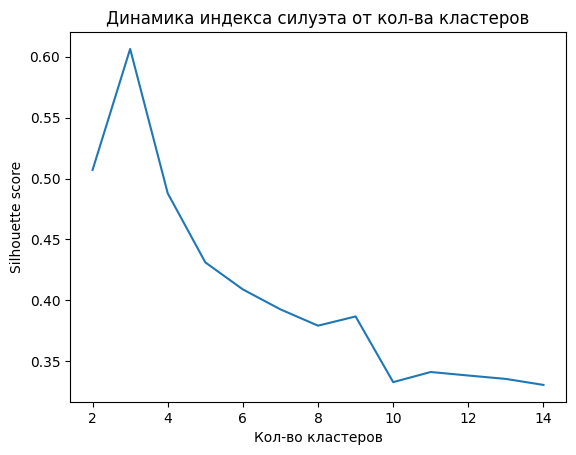

In [194]:

plt.plot(n_clusters_list, score_list)
plt.title('Динамика индекса силуэта от кол-ва кластеров')
plt.xlabel('Кол-во кластеров')
plt.ylabel('Silhouette score')
plt.show()

**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

In [195]:
from sklearn.cluster import DBSCAN

In [196]:
from timed_decorator.simple_timed import timed

#@timed(use_seconds=True)
def bcubed_precision(y_true, y_pred):
  ll =  np.array(list(zip(y_pred, y_true)))
  precision_score_list=[]
  for pred, true in ll:
    true_in_pred_set = len([_ for (p, t) in ll if p==pred and t==true])
    all_in_pred_set = len([_ for (p, r) in ll if p==pred])
    p_score = true_in_pred_set / all_in_pred_set
    precision_score_list.append(p_score)
  return np.mean(np.array(precision_score_list))

def bcubed_recall(y_true, y_pred):
  labels_list =  list(zip(y_pred, y_true))
  recall_score_list=[]
  for pred, true in labels_list:
    true_in_pred_set = len([_ for (p, t) in labels_list if p==pred and t==true])
    all_in_pred_set = len([_ for (p, t) in labels_list if t==true])
    r_score = true_in_pred_set / all_in_pred_set
    recall_score_list.append(r_score)
  return np.mean(np.array(recall_score_list))

def bcubed_fscore(y_true, y_pred):
  precision = bcubed_precision(y_true, y_pred)
  recall = bcubed_recall(y_true, y_pred)
  return 2 * precision * recall / (precision + recall)


y_pred=[1, 0, 0, 1, 1, 1, 1, 1, 0, 0]
y_true=[1, 1, 1, 1, 0, 1, 1, 1, 0, 0]

print(bcubed_precision(y_true=y_true, y_pred=y_pred))
print(bcubed_recall(y_true=y_true, y_pred=y_pred))
print(bcubed_fscore(y_true=y_true, y_pred=y_pred))


0.6333333333333334
0.580952380952381
0.6060130718954249


In [197]:
best_bcubed = 0
best_eps = None
best_min_samples = None

eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = range(2, 10)

In [198]:
for eps in eps_values:
  for min_samples in min_samples_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    pred_labels = dbscan.fit_predict(X)

    if len(set(pred_labels)) > 1:
      bcubed_score = bcubed_fscore(labels, pred_labels)
      if bcubed_score > best_bcubed:
        best_bcubed = bcubed_score
        best_eps = eps
        best_min_samples = min_samples

print(f"Лучшие параметры с метриков BCubed fscore = {best_bcubed}:")
print(f"eps = {best_eps}")
print(f"min_samples = {best_min_samples}")

Лучшие параметры с метриков BCubed fscore = 0.8252380278582961:
eps = 0.4
min_samples = 9


**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

Описание:
1. Модель обучается с использованием EM алгоритма, который итеративно:
2. E step: Вычисляет вероятность принадлежности точки к каждому кластеру.
3. M-step: Обновляет параметры гауссовских компонент (средние, ковариации и веса)
4.


In [199]:
from sklearn.mixture import GaussianMixture

In [200]:
best_bcubed = 0
best_n_components = None
n_components_range = range(2, 7)

In [201]:
for n_components in n_components_range:
  gmm = GaussianMixture(n_components=n_components)
  gmm.fit(X)
  pred_labels = gmm.fit_predict(X)

  if len(set(pred_labels)) > 1:
    bcubed_score = bcubed_fscore(labels, pred_labels)
    if bcubed_score > best_bcubed:
      best_bcubed = bcubed_score
      best_n_components = n_components

print(f"Лучшие параметры с метриков BCubed fscore = {best_bcubed}:")
print(f"n_components = {best_n_components}")

Лучшие параметры с метриков BCubed fscore = 0.9704724639306472:
n_components = 3


In [202]:
gmm = GaussianMixture(n_components=best_n_components)
gmm.fit(X)
pred_labels = gmm.fit_predict(X)

Результат применения Модели GaussianMixture

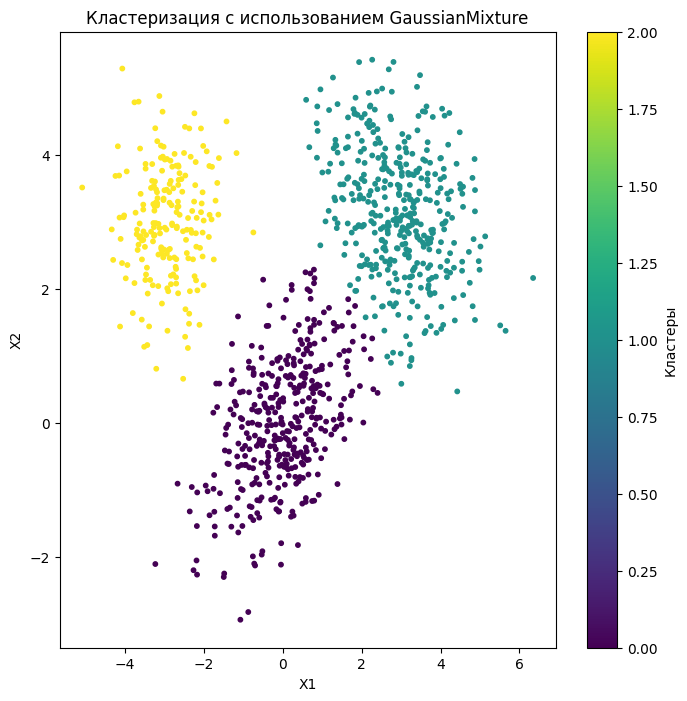

In [203]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=pred_labels, s=10, cmap='viridis')
plt.title('Кластеризация с использованием GaussianMixture')
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()